1. Look at the dataset
    - Different sizes of images
    - Samples with wrong labels
    - Different backgrounds
    - File formats
    - Intensity range
    - Class distribution
2. Pre-process the data
    - Padded the images so they are square
    - Resized the images to a managable size
3. Experimental setup
    -   Single train/val/test split: 70%/ 15%/ 15%
    -   Set data augmentation
    -   Create data loaders
4. Transfer learning
    - SOTA models on imagenet
    - Add and train new top/predictor
    - Fine-tune all or some feature learning layers 
5. Loss and metrics
    -   Loss: categorical cross-entropy
    -   Metrics: Accuracy, sensitivity, specificity, confusion matrix, training and inference time?
6. Set your callbacks and track your experiments
    - Early stopping - patience
    - Model check point
    - Learning rate scheduler
    - Weights and biases (train/val loss)
7. Set your main hyperparameters
    - batch size
    - learning rate
    - number of epochs
8. Train 
    - Train your model
    - Need to write your training code in pure Python and PyTorch or use another library like lightning or ignite
9. Test 
    - Run prediction on your test set
    - Extract relevant metrics
    - Measure inference time

- Other suggestions:
    - Use config files to make experimenting different configs easily
    - Design locally, but run experiments in the cluster



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [751]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

cpu


In [752]:
class TorchVisionDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        #lazily open image
        image = Image.open(file_path)

        #convert to rgb
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label
        


In [753]:

# # Python 3 code to rename multiple
# # files in a directory or folder
 
# # importing os module
# import os
 
# # Function to rename multiple files
# def main():
   
#     folder = "/content/drive/MyDrive/ENSF645_Assign2/severe"
#     for count, filename in enumerate(os.listdir(folder)):
#         dst = f"image_severe {str(count)}.jpg"
#         src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
#         dst =f"{folder}/{dst}"
         
#         # rename() function will
#         # rename all the files
#         os.rename(src, dst)
 
# # Driver Code
# if __name__ == '__main__':
     
#     # Calling main() function
#     main()

In [754]:
images = glob.glob("images/*/*")
images = np.array(images)
labels = np.array([f.split("\\")[-2] for f in images])
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])


115
115
images\mild\1 (1).png
mild


In [755]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype = np.int64)
print(labels_int.shape)
for ii,jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['mild' 'moderate' 'normal' 'severe']
(115,)


In [756]:
for i in range(4):
    print("Label", i, ":", (labels_int == i).sum())

Label 0 : 29
Label 1 : 43
Label 2 : 20
Label 3 : 23


In [757]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100)
sss.get_n_splits(images,labels_int)
dev_index, test_index = next(sss.split(images,labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [758]:
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100)
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 

In [759]:
print("Train set:", train_images.size)
print("Val set:", val_images.size)
print("Test set:", test_images.size)


Train set: 64
Val set: 22
Test set: 29


In [760]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [761]:
#model selection
selected_model=resnet18
pretrained_weights=ResNet18_Weights.IMAGENET1K_V1

In [762]:
torchvision_transform = torch.nn.Sequential(pretrained_weights.transforms(), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip())


torchvision_transform_test = pretrained_weights.transforms()

In [763]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [764]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, num_workers= 0)

In [765]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [766]:
print(get_dataset_stats(trainloader))

(tensor([0.5867, 0.2310, 0.3133]), tensor([0.8118, 0.7641, 0.7679]))


In [767]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [768]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


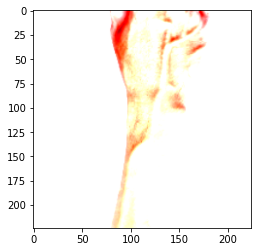

In [769]:
plt.figure()
plt.imshow(train_batch[0].numpy()[4].transpose(1,2,0))
plt.show()

In [770]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False, fixed_feature_extractor=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if pretrained=True
        self.feature_extractor =  selected_model(weights=(pretrained_weights if transfer else None))

        if not fixed_feature_extractor:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x


In [771]:
net = Model(4, (3,224,224), transfer=True, fixed_feature_extractor=False)
net.to(device)

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [772]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.90)

In [773]:
nepochs = 30
PATH = 'EV_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i+1):.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 1.711, val loss: 1.549
Saving model
2,  train loss: 1.233, val loss: 1.074
Saving model
3,  train loss: 0.901, val loss: 0.705
Saving model
4,  train loss: 0.713, val loss: 0.620
Saving model
5,  train loss: 0.681, val loss: 0.604
Saving model
6,  train loss: 0.684, val loss: 0.543
Saving model
7,  train loss: 0.536, val loss: 0.614
8,  train loss: 0.527, val loss: 0.664
9,  train loss: 0.541, val loss: 0.701
10,  train loss: 0.421, val loss: 0.769
11,  train loss: 0.456, val loss: 0.607
12,  train loss: 0.430, val loss: 0.522
Saving model
13,  train loss: 0.404, val loss: 0.573
14,  train loss: 0.402, val loss: 0.581
15,  train loss: 0.388, val loss: 0.476
Saving model
16,  train loss: 0.356, val loss: 0.413
Saving model
17,  train loss: 0.354, val loss: 0.481
18,  train loss: 0.339, val loss: 0.551
19,  train loss: 0.302, val loss: 0.429
20,  train loss: 0.312, val loss: 0.627
21,  train loss: 0.326, val loss: 0.516
22,  train loss: 0.304, val loss: 0.548
23,  train l

In [774]:
# Load the best model to be used in the test set
net = Model(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [775]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 72.41379310344827 %
